### Homework #3 - Labeled Faces in the Wild

This is the README section for A0080485B-A0121261Y-A0121520A submission.

### General Notes about this assignment 

We carried out an experiment involving three different classification models. Using PCA to reduce the dimensionality for the first two models 1. Boosted Decision Tree(Xgboost) and 2.SVM. We then experimented with Convolutional neural networks which produced the best results. The CNN model is located in a different ipynb called hw3-lfw-cnn.ipynb

### Files included with this submission

List the files in your submission here and provide a short 1 line description of each file.  Make sure your submission's files are named and formatted correctly.

README.pdf - This readme, detailing the entire report  
hw3-lfw-svm-xgboost.ipynb - Source code for Xgboost and SVM model   
hw3-lfw-cnn.ipynb - Source code for the Convolutional Neural Network  
hw3-lfw-preprocess.ipynb - Source code for the preprocessing/augmentation of image data  
shape_predictor_68_face_landmarks.dat - Dependency of preprocessing  


## Programming Exercise 1

In [3]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

%matplotlib inline
# Plotting with style! 
import seaborn as sb 

# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

Let's fix the random number generator first, in case we need results that are replicable.

In [5]:
nr.seed(3244)

In [6]:
# load datasets code
rawX = np.load('X_train.npy') # 996,1850 of 996 sample 50,37 pixel image
rawY = np.load('y_train.npy') # 996 col vector
testX = np.load('X_test.npy') # test data

h = 50 # height of image
w = 37 # width of image
n_samples = rawX.shape[0]
n_features = rawX.shape[1]
n_classes = 7

x_train, x_vali, y_train, y_vali = train_test_split(rawX, rawY, test_size=0.25, random_state=42)

# print (n_features)
# print (x_train.shape)
# print (x_vali.shape)
# print (y_train.shape)
# print (y_vali.shape)

1850
(724, 1850)
(242, 1850)
(724,)
(242,)


[ 18.28  33.55  41.1   47.22  52.31  55.34  57.82  60.02  62.14  64.13
  65.74  67.24  68.45  69.55  70.63  71.6   72.5   73.37  74.18  74.92
  75.6   76.24  76.85  77.44  78.02  78.55  79.06  79.54  80.    80.44
  80.83  81.21  81.58  81.94  82.29  82.62  82.95  83.25  83.54  83.82
  84.1   84.37  84.63  84.89  85.13  85.37  85.6   85.83  86.05  86.26
  86.47  86.68  86.88  87.08  87.27  87.46  87.64  87.82  88.    88.17
  88.33  88.49  88.65  88.8   88.95  89.1   89.25  89.39  89.53  89.67
  89.8   89.93  90.06  90.19  90.32  90.44  90.56  90.68  90.8   90.92
  91.03  91.14  91.25  91.36  91.47  91.58  91.68  91.78  91.88  91.98
  92.08  92.17  92.26  92.35  92.44  92.53  92.62  92.71  92.79  92.87
  92.95  93.03  93.11  93.19  93.27  93.34  93.41  93.48  93.55  93.62
  93.69  93.76  93.83  93.9   93.97  94.03  94.09  94.15  94.21  94.27
  94.33  94.39  94.45  94.51  94.57  94.63  94.68  94.73  94.78  94.83
  94.88  94.93  94.98  95.03  95.08  95.13  95.18  95.23  95.28  95.33
  95.3

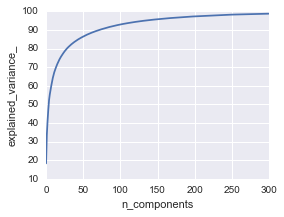

In [8]:
#http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html#sphx-glr-auto-examples-applications-face-recognition-py
#Reference link   
#Running PCA on raw data
    
pca = PCA(n_components = 300,whiten = True) # intial magic number to determine number of components
pca.fit(rawX)

var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print (var1) #Each row shows cummulative variance of having 10 * r features
plt.figure(1, figsize=(4, 3))
plt.plot(var1)
plt.ylabel('explained_variance_')
plt.xlabel('n_components')

print("Projecting the input data on the eigenfaces orthonormal basis")
x_train_pca = pca.transform(x_train)
x_vali_pca = pca.transform(x_vali)


In [9]:
#Model 1 and 2 Preprocessing with PCA
#From the above code, we found 170 components for PCA to be sufficient in describing the dataset.
components = 170
x_train, x_vali, y_train, y_vali = train_test_split(rawX, rawY, test_size=0.20, random_state=42)
pca = PCA(n_components = components, svd_solver='randomized', whiten=True).fit(x_train)
eigenfaces = pca.components_.reshape((components, h, w))

print(eigenfaces.shape)

#Using pca with 170 components to transform the data
x_train_pca = pca.transform(x_train)
x_vali_pca = pca.transform(x_vali)
x_test_pca = pca.transform(testX)



(170, 50, 37)


In [10]:
#------------------------Start of Model 1 --------------------------------------
#Parameters for Xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 9
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 7
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['min_child_weight'] = 24
param['max_delta_step'] = 4
param['gamma'] = 4
param['missing'] = 1
param['alpha'] = 0

In [11]:
#Running this code may take awhile
#Using xgboost as a classifier
xg_train = xgb.DMatrix( x_train_pca, label=y_train)
xg_vali = xgb.DMatrix(x_vali_pca, label=y_vali)

watchlist = [ (xg_train,'train'), (xg_vali, 'vali') ]
num_round = 5000
bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=500);

# get prediction
pred = bst.predict( xg_vali );
bst.save_model('xgb.model')
bst.dump_model('dump.raw.txt')


print ('predicting, classification error=%f' % (sum( int(pred[i]) != y_vali[i] for i in range(len(y_vali))) / float(len(y_vali)) ))


[0]	train-merror:0.506477	vali-merror:0.628866
Multiple eval metrics have been passed: 'vali-merror' will be used for early stopping.

Will train until vali-merror hasn't improved in 500 rounds.
[1]	train-merror:0.466321	vali-merror:0.613402
[2]	train-merror:0.453368	vali-merror:0.592784
[3]	train-merror:0.449482	vali-merror:0.587629
[4]	train-merror:0.449482	vali-merror:0.592784
[5]	train-merror:0.419689	vali-merror:0.603093
[6]	train-merror:0.406736	vali-merror:0.582474
[7]	train-merror:0.406736	vali-merror:0.582474
[8]	train-merror:0.40285	vali-merror:0.56701
[9]	train-merror:0.393782	vali-merror:0.561856
[10]	train-merror:0.380829	vali-merror:0.56701
[11]	train-merror:0.371762	vali-merror:0.561856
[12]	train-merror:0.369171	vali-merror:0.556701
[13]	train-merror:0.358808	vali-merror:0.530928
[14]	train-merror:0.34715	vali-merror:0.520619
[15]	train-merror:0.343264	vali-merror:0.520619
[16]	train-merror:0.334197	vali-merror:0.494845
[17]	train-merror:0.32772	vali-merror:0.5
[18]	tra

In [12]:
dtest = xgb.DMatrix(x_test_pca)
ypred = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
ypred = ypred.reshape(-1,1)

# print ('ImageId,PredictedClass')
# for i in range(322):
#     print ( repr(i) + ","+ repr(ypred[i]) ) 
# Manually paste to csv file, and replace non-digit symbols in data.
#------------------------End of Model 1 --------------------------------------

In [13]:
#------------------------Start of Model 2 --------------------------------------
## By scikit svm classifier
print("Fitting the classifier to the training set")

param_grid = {'C': [700,800,900, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005,0.0008, 0.001, 0.005, 0.01, 0.1,0.3,0.258], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(x_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)





Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=700, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [14]:
print("Predicting people's names on the test set")

y_pred = clf.predict(x_vali_pca)
print(y_pred.shape)

target_name = ['0','1','2','3','4','5','6']

print(classification_report(y_vali, y_pred, target_names=target_name))
print(confusion_matrix(y_vali, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
(194,)
             precision    recall  f1-score   support

          0       1.00      0.64      0.78        11
          1       0.84      0.84      0.84        37
          2       0.79      0.55      0.65        20
          3       0.80      0.96      0.87        68
          4       0.90      0.73      0.81        26
          5       0.86      0.60      0.71        10
          6       0.70      0.86      0.78        22

avg / total       0.82      0.81      0.81       194

[[ 7  1  1  2  0  0  0]
 [ 0 31  0  3  1  0  2]
 [ 0  3 11  5  0  0  1]
 [ 0  1  0 65  0  1  1]
 [ 0  0  2  1 19  0  4]
 [ 0  0  0  3  1  6  0]
 [ 0  1  0  2  0  0 19]]


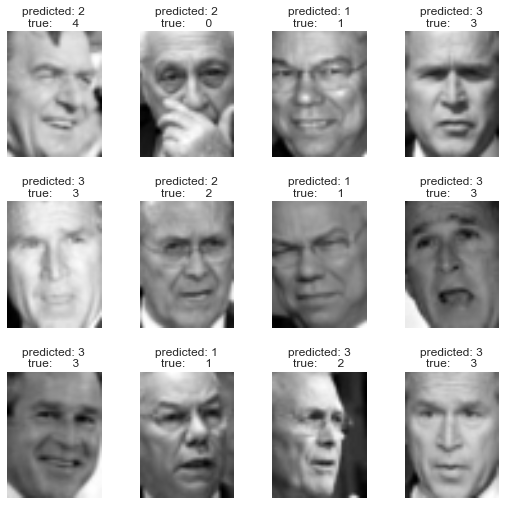

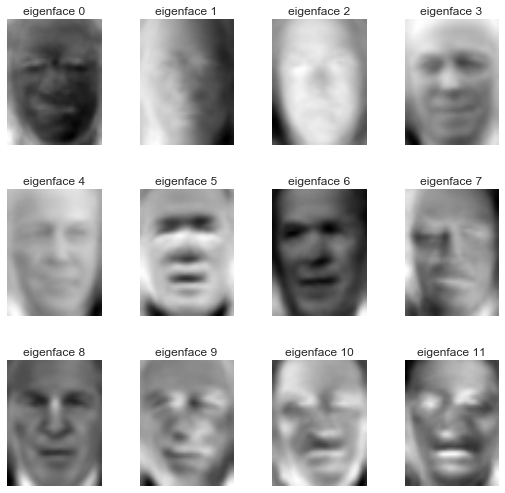

In [15]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]]
    true_name = target_names[y_test[i]]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_vali, target_name, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(x_vali, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# print ('ImageId,PredictedClass')
# for i in range(322):
#     print ( repr(i) + ","+ repr(ypred[i]) ) 
# Manually paste to csv file, and replace non-digit symbols in data.
#------------------------End of Model 2 --------------------------------------

## Statement of Team Work

Please initial (between the square brackets) one of the following statements.

We, A0080485B-A0121261Y-A0121520A, certify that we have followed the CS 3244 Machine Learning class guidelines for homework assignments.  In particular, I expressly vow that I have followed the Facebook rule in discussing with others in doing the assignment and did not take notes (digital or printed) from the discussions.  


We suggest that we should be graded as follows:

full credit for work done.
    
### References

I have refered to the following list of people and websites in preparing my homework submission:

http://xgboost.readthedocs.io/en/latest/get_started/index.html#python  
http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html#sphx-glr-auto-examples-applications-face-recognition-py

